In [2]:
import matplotlib.pyplot as plt
import numpy as np

import pyxdf

In [1]:
WPI_xdf_path = "../HCILab1-Group1.xdf"
CSL_xdf_path = "../CSL_01_10.xdf"

### View XDF Streams

In [68]:
def view_xdf_streams(xdf_path):
    data, header = pyxdf.load_xdf(xdf_path)
    print(header)

    for stream in data:
        stream_name = stream["info"]["name"][0]
        stream_id = stream["info"]["stream_id"]
        stream_srate = stream["info"]["effective_srate"]
        
        print(f'Stream {stream_name} (Stream ID: {stream_id} with sampling rate {stream_srate})')

In [69]:
view_xdf_streams(WPI_xdf_path)

Stream 6: Calculated effective sampling rate 14.5166 Hz is different from specified rate 30.0000 Hz.
Stream 3: Calculated effective sampling rate 215.7338 Hz is different from specified rate 250.0000 Hz.


{'info': defaultdict(<class 'list'>, {'version': ['1.0'], 'datetime': ['2024-10-01T10:11:12-0400']})}
Stream OBS_HCILab1 (Stream ID: 1 with sampling rate 29.985436549324497)
Stream Unicorn_HCILab1 (Stream ID: 4 with sampling rate 250.2536352129169)
Stream OBS_HCILab2 (Stream ID: 6 with sampling rate 14.51660206944906)
Stream Unicorn_HCILab2 (Stream ID: 3 with sampling rate 215.7337715477953)
Stream Unicorn_CSL_LabPC (Stream ID: 5 with sampling rate 249.51284897876354)
Stream OBS_CSL_Laptop (Stream ID: 2 with sampling rate 29.99983902052693)


In [70]:
view_xdf_streams(CSL_xdf_path)

Stream 5: Calculated effective sampling rate 14.5717 Hz is different from specified rate 30.0000 Hz.


{'info': defaultdict(<class 'list'>, {'version': ['1.0'], 'datetime': ['2024-10-01T16:10:18+0200']})}
Stream OBS_CSL_Laptop (Stream ID: 1 with sampling rate 30.000000314595177)
Stream Unicorn_CSL_Laptop (Stream ID: 2 with sampling rate 250.18745445436724)
Stream Unicorn_CSL_LabPC (Stream ID: 3 with sampling rate 249.52195379921127)
Stream OBS_CSL_LabPC (Stream ID: 4 with sampling rate 60.00000282970564)
Stream OBS_HCILab2 (Stream ID: 5 with sampling rate 14.571749976822883)
Stream Unicorn_HCILab1 (Stream ID: 6 with sampling rate 250.25592603706266)


In [6]:
def view_stream_keys(xdf_path):
    data, header = pyxdf.load_xdf(xdf_path)
    
    # Print all keys in the stream to inspect the structure
    print(f"Keys in a stream:")
    for key in data[0].keys():
        print(f"- {key}")

view_stream_keys(WPI_xdf_path)

Stream 6: Calculated effective sampling rate 14.5166 Hz is different from specified rate 30.0000 Hz.
Stream 3: Calculated effective sampling rate 215.7338 Hz is different from specified rate 250.0000 Hz.


Keys in a stream:
- info
- footer
- time_series
- time_stamps
- clock_times
- clock_values


In [7]:
def examine_timestamps_length(xdf_path):
    data, header = pyxdf.load_xdf(xdf_path)
    
    for stream in data:
        stream_name = stream["info"]["name"][0]
        
        time_stamps = stream["time_stamps"]
        
        print(f'Stream {stream_name} has {len(time_stamps)} time stamps, starting with {time_stamps[0]}')
        
        time_series = stream["time_series"]
        if stream_name.startswith("OBS"):
            print(f"Stream {stream_name} with time series (UNIX) begins with {time_series[0][0]}")

# Examine the length of all time stamps in each stream for both XDF files
print("WPI HCI Lab Streams:")
examine_timestamps_length(WPI_xdf_path)

print("\nCSL Lab Streams:")
examine_timestamps_length(CSL_xdf_path)

WPI HCI Lab Streams:


Stream 6: Calculated effective sampling rate 14.5166 Hz is different from specified rate 30.0000 Hz.
Stream 3: Calculated effective sampling rate 215.7338 Hz is different from specified rate 250.0000 Hz.


Stream OBS_HCILab1 has 120921 time stamps, starting with 56793.94837631806
Stream OBS_HCILab1 with time series (UNIX) begins with 1727791872.975
Stream Unicorn_HCILab1 has 1009144 time stamps, starting with 56794.38196600928
Stream OBS_HCILab2 has 61069 time stamps, starting with 56683.57279925809
Stream OBS_HCILab2 with time series (UNIX) begins with 1727791892.957
Stream Unicorn_HCILab2 has 857742 time stamps, starting with 56823.3321161977
Stream Unicorn_CSL_LabPC has 985886 time stamps, starting with 56793.539689118654
Stream OBS_CSL_Laptop has 120966 time stamps, starting with 56794.65596391625
Stream OBS_CSL_Laptop with time series (UNIX) begins with 1727791873.071

CSL Lab Streams:


Stream 5: Calculated effective sampling rate 14.5717 Hz is different from specified rate 30.0000 Hz.


Stream OBS_CSL_Laptop has 119338 time stamps, starting with 4858783.043931104
Stream OBS_CSL_Laptop with time series (UNIX) begins with 1727791818.471
Stream Unicorn_CSL_Laptop has 995227 time stamps, starting with 4858782.925259427
Stream Unicorn_CSL_LabPC has 992670 time stamps, starting with 4858781.894095449
Stream OBS_CSL_LabPC has 7868 time stamps, starting with 4858783.037595432
Stream OBS_CSL_LabPC with time series (UNIX) begins with 1727791819.602
Stream OBS_HCILab2 has 60141 time stamps, starting with 4858628.17170826
Stream OBS_HCILab2 with time series (UNIX) begins with 1727791838.691
Stream Unicorn_HCILab1 has 995460 time stamps, starting with 4858783.100935575


### Sync Streams!!

In [58]:
def sync_streams(data_streams_1, data_streams_2):
    
    """
    Sync the data by trimming time_stamp and time_series streams so that all EEG and Unicorn Streams begin at the same time
    
    Parameters:
    - data_streams_1: Stream data from WPI HCI Lab xdf file
    - data_streams_2: Stream data from CSL Lab xdf file
    """
    
    # Holds the 8 streams (4 OBS and 4 Unicorn)
    streams = {}
    
    # Create mappings of the 8 stream names to streams
    for stream in data_streams_1:
        stream_name = stream["info"]["name"][0]
        
        if stream_name in ["OBS_HCILab1", "Unicorn_HCILab1", "OBS_HCILab2", "Unicorn_HCILab2"]:
            streams[stream_name] = stream
            
    for stream in data_streams_2:
        stream_name = stream["info"]["name"][0]
        
        if stream_name in ["OBS_CSL_Laptop", "Unicorn_CSL_Laptop", "OBS_CSL_LabPC", "Unicorn_CSL_LabPC"]:
            streams[stream_name] = stream
    
    # From the OBS Video (when Chris says "Begin" and "Time's Up")
    start_unix_timestamp = 1727792156.738
    end_unix_timestamp = 1727795730.971
    duration = end_unix_timestamp - start_unix_timestamp
    frames = 250 * duration
    
    # Trim all the other streams based on the latest Unix timestamp
    # for OBS_stream_name, EEG_stream_name in [("OBS_HCILab1", "Unicorn_HCILab1"), ("OBS_HCILab2", "Unicorn_HCILab2"), ("OBS_CSL_Laptop", "Unicorn_CSL_Laptop"), ("OBS_CSL_LabPC", "Unicorn_CSL_LabPC")]:
    for OBS_stream_name, EEG_stream_name in [("OBS_HCILab1", "Unicorn_HCILab1"), ("OBS_HCILab2", "Unicorn_HCILab2"), ("OBS_CSL_Laptop", "Unicorn_CSL_Laptop")]:
        OBS_stream = streams[OBS_stream_name]
        EEG_stream = streams[EEG_stream_name]
        
        # First, find the LabRecorder timestamp in the OBS stream that corresponds to the start and end Unix timestamp
        OBS_unix_times = [ts[0] for ts in OBS_stream["time_series"]]
        start_OBS_index = np.searchsorted(OBS_unix_times, start_unix_timestamp)
        end_OBS_index = np.searchsorted(OBS_unix_times, end_unix_timestamp)
        
        start_labrecorder_timestamp = OBS_stream["time_stamps"][start_OBS_index]
        end_labrecorder_timestamp = OBS_stream["time_stamps"][end_OBS_index]
        
        # Find the index in the EEG stream where this LabRecorder timestamp occurs
        start_EEG_index = np.searchsorted(EEG_stream["time_stamps"], start_labrecorder_timestamp)
        end_EEG_index = np.searchsorted(EEG_stream["time_stamps"], end_labrecorder_timestamp)
        
        # Trim all the data in the OBS and EEG streams based on this index
        OBS_stream["time_stamps"] = OBS_stream["time_stamps"][start_OBS_index:end_OBS_index]
        OBS_stream["time_series"] = OBS_stream["time_series"][start_OBS_index:end_OBS_index]
        EEG_stream["time_stamps"] = EEG_stream["time_stamps"][start_EEG_index:end_EEG_index]
        EEG_stream["time_series"] = EEG_stream["time_series"][start_EEG_index:end_EEG_index]
    
    return streams


In [59]:
# Load the XDF data for both labs
WPI_data_streams, WPI_header = pyxdf.load_xdf(WPI_xdf_path)
CSL_data_streams, CSL_header = pyxdf.load_xdf(CSL_xdf_path)

Stream 6: Calculated effective sampling rate 14.5166 Hz is different from specified rate 30.0000 Hz.
Stream 3: Calculated effective sampling rate 215.7338 Hz is different from specified rate 250.0000 Hz.
Stream 5: Calculated effective sampling rate 14.5717 Hz is different from specified rate 30.0000 Hz.


In [60]:
# Before syncing the streams, let's examine the time_stamps and time_series in both files
def print_time_stamps_and_series(data_streams):
    for stream in data_streams:
        stream_name = stream["info"]["name"][0]
        print(f'\nStream {stream_name} has {len(stream["time_stamps"])} time stamps and {len(stream["time_series"])} time series')
        
        if len(stream["time_stamps"]) > 0:
            print(f'Time stamps: [{stream["time_stamps"][0]} ... {stream["time_stamps"][-1]}]')
        
        if stream_name.startswith("OBS") and len(stream["time_series"]) > 0:
            print(f'Time series (UNIX): [{stream["time_series"][0][0]} ... {stream["time_series"][-1][0]}]')
        
print("WPI HCI Lab Streams before syncing:")
print_time_stamps_and_series(WPI_data_streams)

print("\nCSL Lab Streams before syncing:")
print_time_stamps_and_series(CSL_data_streams)

WPI HCI Lab Streams before syncing:

Stream OBS_HCILab1 has 120921 time stamps and 120921 time series
Time stamps: [56793.94837631806 ... 60826.57269000918]
Time series (UNIX): [1727791872.975 ... 1727795905.375]

Stream Unicorn_HCILab1 has 1009144 time stamps and 1009144 time series
Time stamps: [56794.38196600928 ... 60826.86284536544]

Stream OBS_HCILab2 has 61069 time stamps and 61069 time series
Time stamps: [56683.57279925809 ... 60890.37793320787]
Time series (UNIX): [1727791892.957 ... 1727795925.391]

Stream Unicorn_HCILab2 has 857742 time stamps and 857742 time series
Time stamps: [56823.3321161977 ... 60799.25638114239]

Stream Unicorn_CSL_LabPC has 985886 time stamps and 985886 time series
Time stamps: [56793.539689118654 ... 60750.5087719986]

Stream OBS_CSL_Laptop has 120966 time stamps and 120966 time series
Time stamps: [56794.65596391625 ... 60826.8442674134]
Time series (UNIX): [1727791873.071 ... 1727795905.238]

CSL Lab Streams before syncing:

Stream OBS_CSL_Laptop

In [61]:
# Sync the streams based on the shared stream's timestamp
streams = sync_streams(WPI_data_streams, CSL_data_streams)

In [62]:
# manually sync Stream Unicorn_CSL_LabPC for Group 1 and 2
Unicorn_CSL_LabPC_stream = streams["Unicorn_CSL_LabPC"]

# calculated by: after_Unicorn_CSL_Laptop stream starting time stamp - (diff between before_Unicorn_CSL_Laptop stream starting time stamp and before_Unicorn_CSL_LabPC stream starting time stamp)
start_cutoff_timestamp = 4859121.311531116 - (4858782.925259427 - 4858781.894095449)
start_cutoff_index = np.searchsorted(Unicorn_CSL_LabPC_stream["time_stamps"], start_cutoff_timestamp)

# calculated by: after_Unicorn_CSL_Laptop stream ENDING time stamp - (diff between before_Unicorn_CSL_Laptop stream ENDING time stamp and before_Unicorn_CSL_LabPC stream ENDING time stamp)
end_cutoff_timestamp = 4862695.543505603 - (4862760.846540175 - 4862760.177315814)
end_cutoff_index = np.searchsorted(Unicorn_CSL_LabPC_stream["time_stamps"], end_cutoff_timestamp)

Unicorn_CSL_LabPC_stream["time_stamps"] = Unicorn_CSL_LabPC_stream["time_stamps"][start_cutoff_index:end_cutoff_index]
Unicorn_CSL_LabPC_stream["time_series"] = Unicorn_CSL_LabPC_stream["time_series"][start_cutoff_index:end_cutoff_index]

In [63]:
print("WPI HCI Lab Streams AFTER syncing:")
print_time_stamps_and_series(WPI_data_streams)

print("\nCSL Lab Streams AFTER syncing:")
print_time_stamps_and_series(CSL_data_streams)

WPI HCI Lab Streams AFTER syncing:

Stream OBS_HCILab1 has 107175 time stamps and 107175 time series
Time stamps: [57077.85286509124 ... 60652.05463647341]
Time series (UNIX): [1727792156.741 ... 1727795730.941]

Stream Unicorn_HCILab1 has 894465 time stamps and 894465 time series
Time stamps: [57077.85437138842 ... 60652.084165651904]

Stream OBS_HCILab2 has 52491 time stamps and 52491 time series
Time stamps: [57011.13156017921 ... 60627.02206717181]
Time series (UNIX): [1727792156.741 ... 1727795730.959]

Stream Unicorn_HCILab2 has 780085 time stamps and 780085 time series
Time stamps: [57011.13306263052 ... 60627.09044871223]

Stream Unicorn_CSL_LabPC has 985886 time stamps and 985886 time series
Time stamps: [56793.539689118654 ... 60750.5087719986]

Stream OBS_CSL_Laptop has 120966 time stamps and 120966 time series
Time stamps: [56794.65596391625 ... 60826.8442674134]
Time series (UNIX): [1727791873.071 ... 1727795905.238]

CSL Lab Streams AFTER syncing:

Stream OBS_CSL_Laptop h

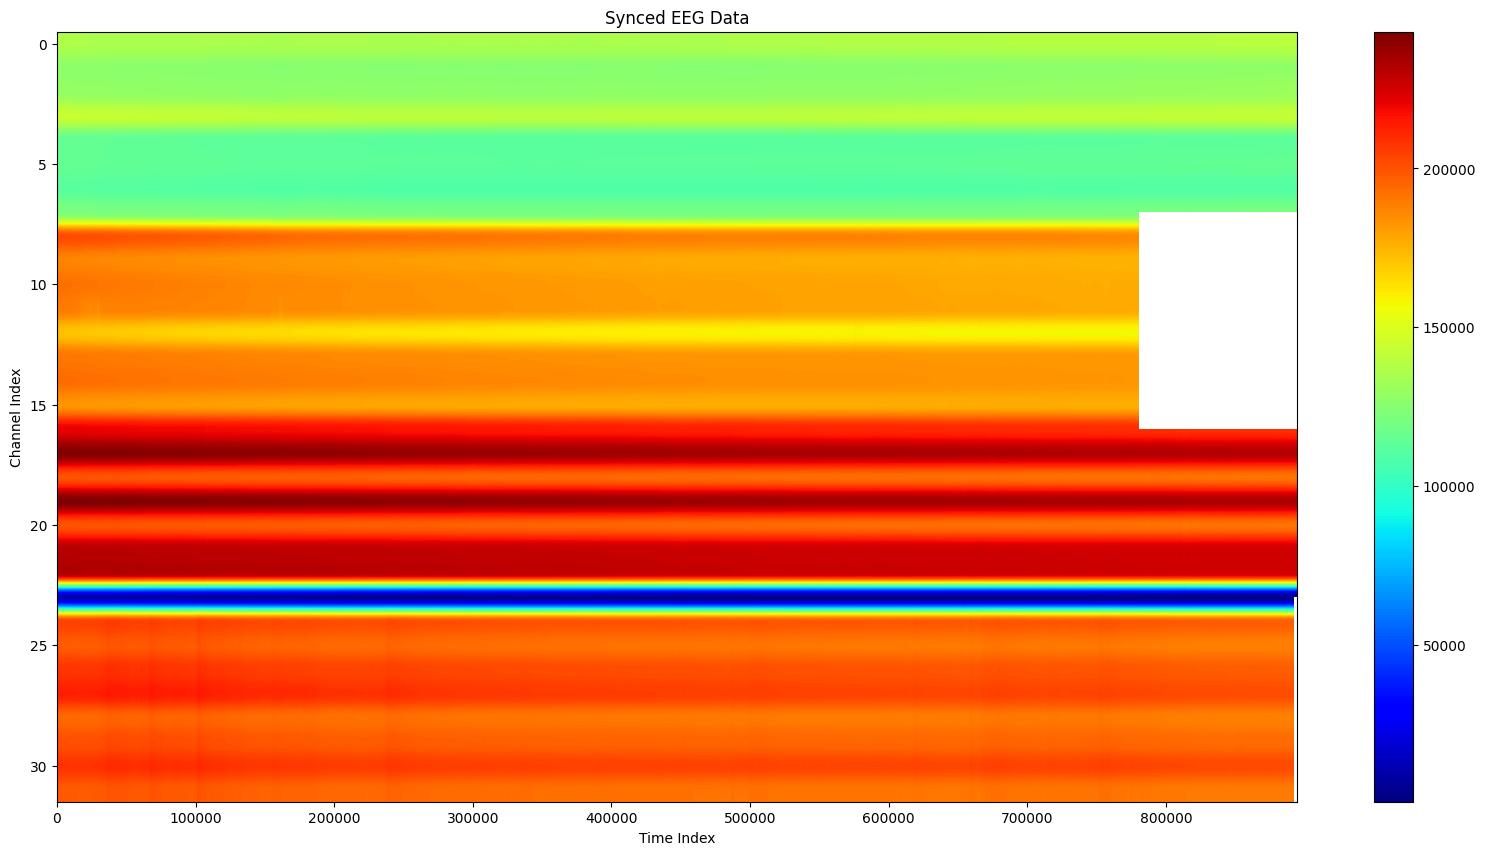

In [65]:
import scipy.io

# find the max length of time_series in all EEG streams to establish dimensions for synced EEG streams
max_length = 0

for stream_name in ["Unicorn_HCILab1", "Unicorn_HCILab2", "Unicorn_CSL_Laptop", "Unicorn_CSL_LabPC"]:
    max_length = max(max_length, len(streams[stream_name]["time_series"]))

# Create an np array to hold the synced EEG data with dimensions (max_length, 4 * 8)
synced_EEG_data = np.full((max_length, 4 * 8), np.nan)

# Fill in the synced EEG data
for j, stream_name in enumerate(["Unicorn_HCILab1", "Unicorn_HCILab2", "Unicorn_CSL_Laptop", "Unicorn_CSL_LabPC"]):
    EEG_stream = streams[stream_name]
    
    for time_index, eeg_data in enumerate(EEG_stream["time_series"]):
        synced_EEG_data[time_index, j * 8:(j + 1) * 8] = eeg_data[0:8]

# Visualize the synced EEG data
plt.figure(figsize=(20, 10))
plt.imshow(synced_EEG_data.T, aspect='auto', cmap='jet')
plt.colorbar()
plt.title("Synced EEG Data")
plt.xlabel("Time Index")
plt.ylabel("Channel Index")
plt.show()

# Download the EEG data as an .mat file
scipy.io.savemat('task_cutoff_EEG_data_1.mat', {'task_cutoff_EEG_data_1': synced_EEG_data})